## Stardist training example

This notebook shows how to train a Stardist model.  After training go back and load the model into ```napari-easy-augment-batch-dl``` to test the model. 

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [2]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [2]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [3]:
data_path = r'../../data'
parent_path = os.path.join(data_path, 'ladybugs1')
n_rays = 32

train_path = os.path.join(parent_path , 'patches')

with open(os.path.join(train_path , 'info.json'), 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = os.path.join(train_path , 'ground truth0')
label_patch_path = os.path.join(train_path , 'input0' )

model_path = os.path.join(parent_path , 'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YXC


## Use a helper to collect the training data

The helper will also optionally normalize the inputs.  However in this case we set ```normalize_input``` to ```False```.

Normalization is a tricky issue sometimes it makes sense to normalize before creating patches, such that the data is normalized based on statistics of a larger region, closer to the normalization range that will be used for prediction. 

In [4]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist
type X  <class 'list'>
type Y  <class 'list'>


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].


(256, 256, 3) (256, 256)
-0.003937008 1.0
0 26


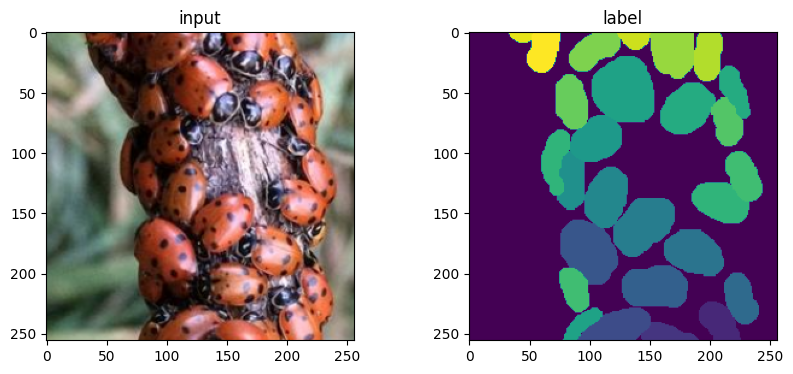

In [5]:
n=35
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
print(Y[n].min(), Y[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

In [6]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

print('type X_train ', type(X_train))

type X_train  <class 'numpy.ndarray'>


## Create stardist model

In this cell we create the model.  Make sure to rename the model and give it a descriptive name that conveys the training data and setting used. 

In [7]:
from stardist.models import StarDist2D, Config2D

if axes == 'YXC':
    n_channel_in =3
else:
    n_channel_in = 1

model_name = "stardist_for_ladybugs_2"
new_model = True

if new_model:

    config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=3)
    model = StarDist2D(config=config, name=model_name, basedir=model_path)
else:
    model = StarDist2D(config=None, name=model_name, basedir=model_path)

Using default values: prob_thresh=0.5, nms_thresh=0.4.


## Train the model

In [8]:
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=5, steps_per_epoch=200) 

Epoch 1/5
200/200 [==============================] - 97s 448ms/step - loss: 2.5035 - prob_loss: 0.4817 - dist_loss: 10.1089 - prob_kld: 0.2694 - dist_relevant_mae: 10.1079 - dist_relevant_mse: 176.8633 - dist_dist_iou_metric: 0.2999 - val_loss: 1.9364 - val_prob_loss: 0.4411 - val_dist_loss: 7.4762 - val_prob_kld: 0.2333 - val_dist_relevant_mae: 7.4750 - val_dist_relevant_mse: 97.5727 - val_dist_dist_iou_metric: 0.3775 - lr: 3.0000e-04
Epoch 2/5
200/200 [==============================] - 86s 433ms/step - loss: 1.8925 - prob_loss: 0.4283 - dist_loss: 7.3213 - prob_kld: 0.2158 - dist_relevant_mae: 7.3200 - dist_relevant_mse: 95.1921 - dist_dist_iou_metric: 0.4314 - val_loss: 1.4672 - val_prob_loss: 0.3314 - val_dist_loss: 5.6791 - val_prob_kld: 0.1235 - val_dist_relevant_mae: 5.6779 - val_dist_relevant_mse: 61.3893 - val_dist_dist_iou_metric: 0.4838 - lr: 3.0000e-04
Epoch 3/5
200/200 [==============================] - 88s 438ms/step - loss: 1.4141 - prob_loss: 0.3277 - dist_loss: 5.4322 

In [12]:
#model.optimize_thresholds(X_train, Y_train)

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].


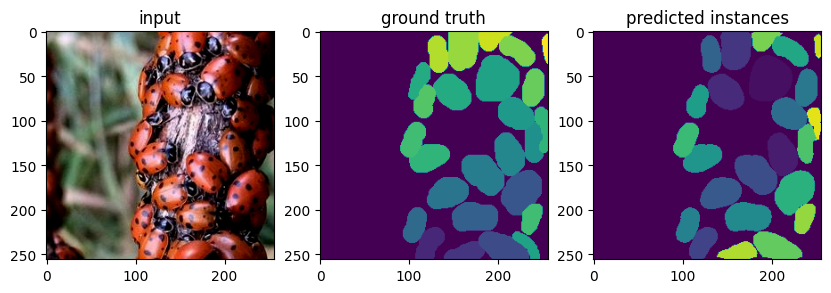

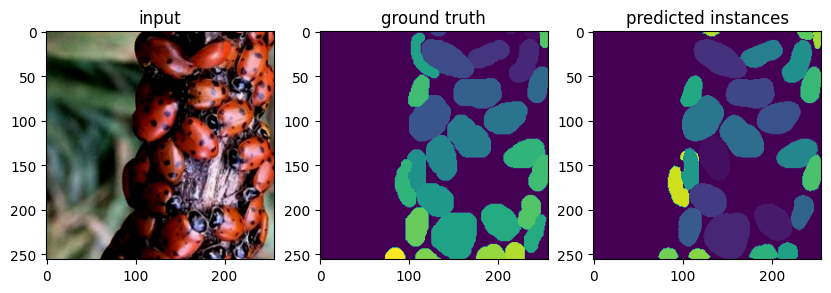

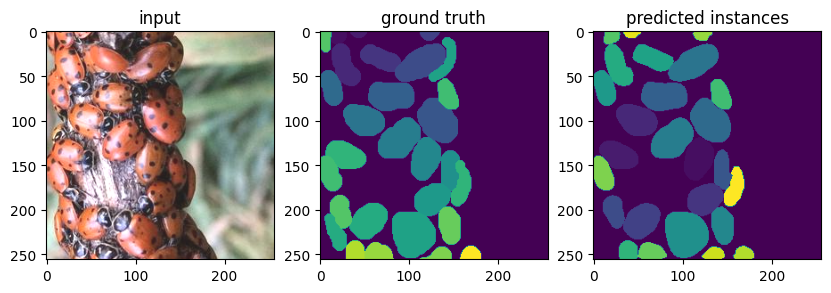

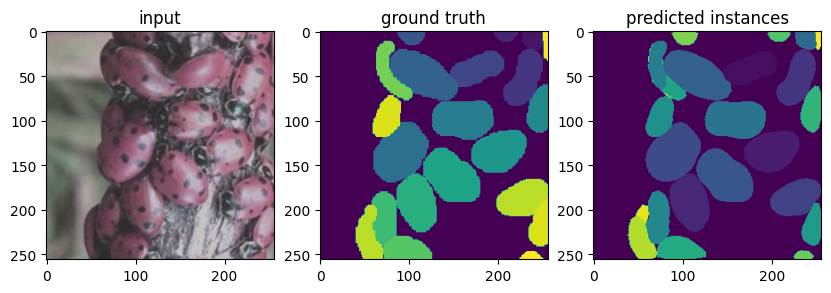

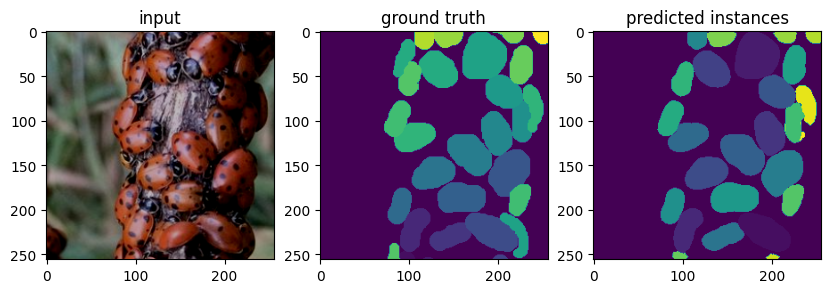

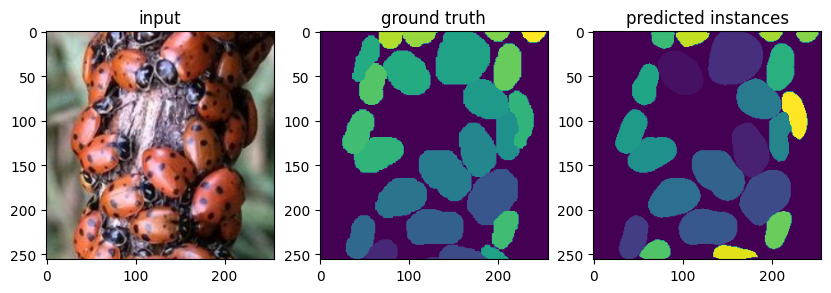

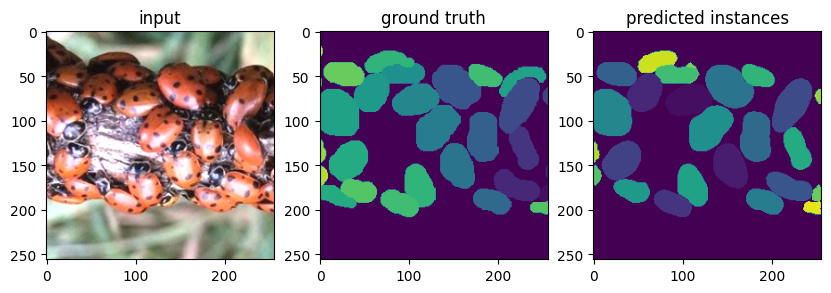

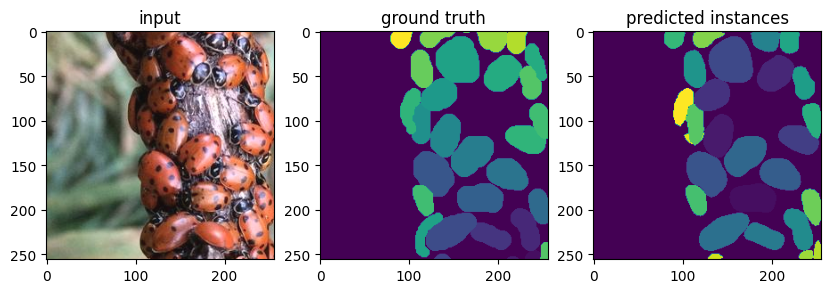

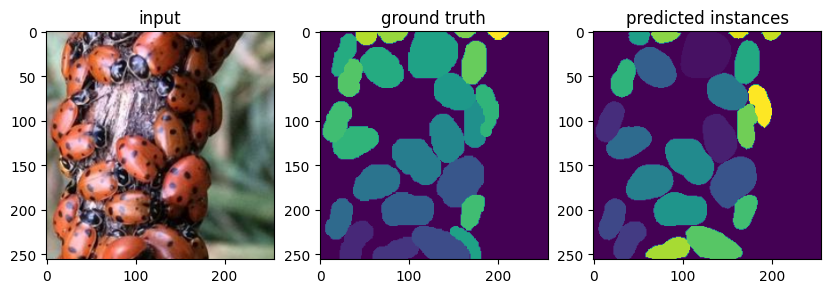

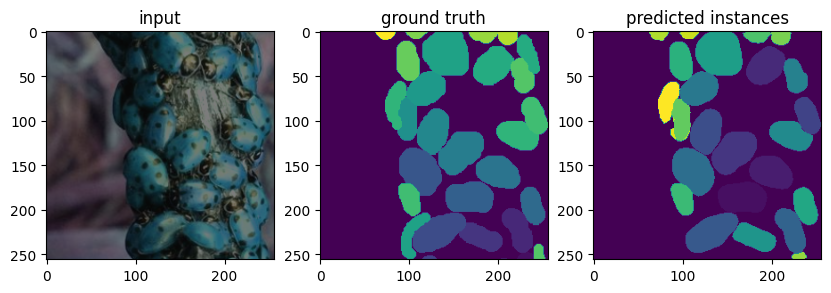

In [11]:
for n in range(10):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.9)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)
